### KeyDiff Sample Code

- This is a sample code that implements the key ideas of the following paper.
  - [https://arxiv.org/pdf/2504.15364](https://arxiv.org/pdf/2504.15364)
- Insights
  - `Anchor KeyDiff` retains keys that are less similar to the `anchor` (the mean of all keys). In other words, it follows a strategy that selects keys farthest from the global mean—that is, outliers or more diverse keys.
  - In the test dataset, half of the data points are located near the `query` (similar keys), while the other half belong to random or noisy clusters.
  - Because of this setup, the `anchor` (mean) tends to be biased toward the query side, and as a result, `Anchor KeyDiff` retains keys that are farther from the anchor—mostly extreme points from random clusters.
  - Consequently, when evaluated based on `query similarity`, its performance may appear worse. In contrast, methods like KMeans (similar to TOVA) can achieve better apparent results by ensuring broader spatial coverage. Likewise, Sink (Last-N) may also appear relatively good, since random and diverse samples are distributed toward the latter part of the dataset.
  - Additionally, since the visualization (`PCA`) compresses high-dimensional structures into 2D, the apparent “goodness” in the plots may be distorted.
  - However, according to the code’s statistical outputs (e.g., `query_mean`), `Anchor KeyDiff` indeed shows the **lowest similarity** overall.

In [1]:
!pip install numpy torch scikit-learn matplotlib

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from typing import Tuple, List

In [3]:
# -------------------------
# KeyDiff (anchor-based) implementation (numpy)
# -------------------------
def anchor_keydiff_select(keys: np.ndarray, max_keep: int) -> np.ndarray:
    """
    keys: (n, d) numpy
    returns: kept indices (ascending order)
    KeyDiff: compute anchor = mean(keys), cos_sim per key, keep keys with smallest cos_sim
    """
    n, d = keys.shape
    if n <= max_keep:
        return np.arange(n, dtype=np.int64)
    anchor = np.mean(keys, axis=0)  # (d,)
    anchor_norm = np.linalg.norm(anchor) + 1e-12
    key_norms = np.linalg.norm(keys, axis=1) + 1e-12
    cos_sim = (keys @ anchor) / (key_norms * anchor_norm)  # higher => closer to anchor
    # We want to retain keys that are *less similar* to anchor (more diverse)
    keep_idx = np.argsort(cos_sim)[:max_keep]
    return np.sort(keep_idx).astype(np.int64)

In [4]:
# -------------------------
# Sink (recent-last N)
# -------------------------
def sink_select(keys: np.ndarray, max_keep: int) -> np.ndarray:
    n = keys.shape[0]
    if n <= max_keep:
        return np.arange(n, dtype=np.int64)
    start = n - max_keep
    keep_idx = np.arange(start, n, dtype=np.int64)
    return keep_idx

In [5]:
# -------------------------
# TOVA approximate: KMeans diverse selection
# -------------------------
def tova_kmeans_select(keys: np.ndarray, max_keep: int, random_state: int = 0) -> np.ndarray:
    """
    Use KMeans with k=max_keep and pick the closest point to each centroid.
    If n < max_keep, return all indices.
    """
    n, d = keys.shape
    if n <= max_keep:
        return np.arange(n, dtype=np.int64)
    # KMeans might be unstable for large dims; use sklearn KMeans
    k = max_keep
    km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    km.fit(keys)
    centers = km.cluster_centers_  # (k, d)
    labels = km.labels_            # (n,)
    chosen = []
    for ci in range(k):
        idxs = np.where(labels == ci)[0]
        if idxs.size == 0:
            # fallback: pick a random unused index
            # (should be rare)
            unused = np.setdiff1d(np.arange(n), np.array(chosen, dtype=np.int64))
            if unused.size > 0:
                chosen.append(int(unused[0]))
        else:
            pts = keys[idxs]
            # compute distances to centroid
            dists = np.sum((pts - centers[ci]) ** 2, axis=1)
            best_local = idxs[np.argmin(dists)]
            chosen.append(int(best_local))
    chosen = np.array(sorted(set(chosen)))
    # if duplicates reduced below k (due to duplicates), fill up with farthest-from-centroid heuristic
    if chosen.size < k:
        # pick remaining highest-distance-to-nearest-chosen
        remaining = np.setdiff1d(np.arange(n), chosen)
        if remaining.size > 0:
            # compute distance to closest already chosen
            chosen_pts = keys[chosen] if chosen.size > 0 else np.zeros((0, d))
            if chosen_pts.size == 0:
                fill = remaining[: k - chosen.size]
            else:
                dists_to_chosen = np.min(((keys[remaining, None, :] - chosen_pts[None, :, :]) ** 2).sum(axis=2), axis=1)
                fill_idx = np.argsort(-dists_to_chosen)[: (k - chosen.size)]
                fill = remaining[fill_idx]
            chosen = np.sort(np.concatenate([chosen, fill]))
    # ensure length exactly k
    if chosen.size > k:
        chosen = chosen[:k]
    return chosen.astype(np.int64)

In [6]:
# -------------------------
# Utility: cosine similarities of selected indices vs anchor & query
# -------------------------
def cos_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float((a @ b) / ((np.linalg.norm(a) * np.linalg.norm(b) + 1e-12)))

def stats_for_selection(keys: np.ndarray, sel_idx: np.ndarray, anchor: np.ndarray, query: np.ndarray):
    sel_keys = keys[sel_idx]
    sims_anchor = (sel_keys @ anchor) / (np.linalg.norm(sel_keys, axis=1) * (np.linalg.norm(anchor) + 1e-12))
    sims_query = (sel_keys @ query) / (np.linalg.norm(sel_keys, axis=1) * (np.linalg.norm(query) + 1e-12))
    return {
        "anchor_mean": float(np.mean(sims_anchor)),
        "anchor_min": float(np.min(sims_anchor)),
        "anchor_max": float(np.max(sims_anchor)),
        "query_mean": float(np.mean(sims_query)),
        "query_min": float(np.min(sims_query)),
        "query_max": float(np.max(sims_query)),
    }


In [7]:
# -------------------------
# Main visualization routine
# -------------------------
def visualize_policies(num_keys=400, dim=64, keep_frac=0.35, seed=123):
    np.random.seed(seed)
    # generate one normalized query
    query = np.random.randn(dim)
    query /= np.linalg.norm(query)

    # construct keys: half near-query cluster, half random/noisy / duplicates to mimic redundancy
    n_similar = num_keys // 2
    n_random = num_keys - n_similar
    # similar: small noise around query
    similar_keys = query[None, :] + 0.06 * np.random.randn(n_similar, dim)
    # random cluster shaped spiral-ish: just random
    random_keys = np.random.randn(n_random, dim) + 0.5 * np.random.randn(1, dim)
    keys = np.vstack([similar_keys, random_keys])
    # normalize key vectors
    keys = keys / (np.linalg.norm(keys, axis=1, keepdims=True) + 1e-12)

    # values can be identical to keys here
    values = keys.copy()

    max_keep = int(np.ceil(num_keys * keep_frac))
    print(f"Total keys: {num_keys}, keep per policy: {max_keep}")

    # anchor (global mean) and its normalized version
    anchor = np.mean(keys, axis=0)
    anchor = anchor / (np.linalg.norm(anchor) + 1e-12)

    # policy selections
    keydiff_idx = anchor_keydiff_select(keys, max_keep)
    tova_idx = tova_kmeans_select(keys, max_keep, random_state=seed)
    sink_idx = sink_select(keys, max_keep)

    # compute stats
    kd_stats = stats_for_selection(keys, keydiff_idx, anchor, query)
    tova_stats = stats_for_selection(keys, tova_idx, anchor, query)
    sink_stats = stats_for_selection(keys, sink_idx, anchor, query)

    print("KeyDiff stats:", kd_stats)
    print("")
    print("TOVA(KMeans) stats:", tova_stats)
    print("")
    print("Sink(Last-N) stats:", sink_stats)
    print("")

    # PCA: include all keys, and appended selected sets so that projection is shared
    combined = np.vstack([
        keys,
        keys[keydiff_idx],
        keys[tova_idx],
        keys[sink_idx],
    ])
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined)

    n = num_keys
    kd_start = n
    kd_end = kd_start + keydiff_idx.size
    tova_start = kd_end
    tova_end = tova_start + tova_idx.size
    sink_start = tova_end
    sink_end = sink_start + sink_idx.size
    all_points = reduced[:n]
    kd_points = reduced[kd_start:kd_end]
    tova_points = reduced[tova_start:tova_end]
    sink_points = reduced[sink_start:sink_end]
    
    # Plotting 4 subplots: (a) Sink, (b) TOVA, (c) KeyDiff, (d) Retained keys only
    fig, axes = plt.subplots(1, 4, figsize=(22, 5))
    policies = [
        ("(a) Sink", sink_points, sink_idx),
        ("(b) TOVA", tova_points, tova_idx),
        ("(c) KeyDiff", kd_points, keydiff_idx),
    ]
    # First three panels: retained (blue) vs evicted (orange)
    for ax, (title, kept_points, kept_idx) in zip(axes[:3], policies):
        evicted_mask = np.ones(all_points.shape[0], dtype=bool)
        evicted_mask[kept_idx] = False
        evicted_points = all_points[evicted_mask]
        ax.scatter(evicted_points[:, 0], evicted_points[:, 1], c="orange", alpha=0.35, s=18, label="Evicted")
        ax.scatter(kept_points[:, 0], kept_points[:, 1], c="blue", alpha=0.85, s=22, label="Retained")
        ax.set_title(title)
        ax.set_xlabel("PCA dim 1")
        ax.set_ylabel("PCA dim 2")
        ax.legend(frameon=True)
        ax.grid(alpha=0.25)

    # Panel (d): retained keys only for each method together
    ax = axes[3]
    ax.scatter(sink_points[:, 0], sink_points[:, 1], c="#2ca02c", alpha=0.9, s=20, label="Sink retained")
    ax.scatter(tova_points[:, 0], tova_points[:, 1], c="#9467bd", alpha=0.9, s=20, label="TOVA retained")
    ax.scatter(kd_points[:, 0], kd_points[:, 1], c="#1f77b4", alpha=0.9, s=20, label="KeyDiff retained")
    ax.set_title("(d) Retained keys only")
    ax.set_xlabel("PCA dim 1")
    ax.set_ylabel("PCA dim 2")
    ax.legend(frameon=True)
    ax.grid(alpha=0.25)

    plt.suptitle("PCA Visualizations: (a) Sink, (b) TOVA, (c) KeyDiff, (d) Retained only")
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

    # print selected index lists for inspection
    print("KeyDiff kept indices (example first 20):", keydiff_idx[:20].tolist())
    print("TOVA kept indices (example first 20):", tova_idx[:20].tolist())
    print("Sink kept indices (example first 20):", sink_idx[:20].tolist())

Total keys: 400, keep per policy: 140
KeyDiff stats: {'anchor_mean': 0.1440536095036508, 'anchor_min': -0.08736039158381184, 'anchor_max': 0.26513469729327577, 'query_mean': -0.04782897746197993, 'query_min': -0.23345929329242202, 'query_max': 0.15854827521241466}

TOVA(KMeans) stats: {'anchor_mean': 0.22172521541364906, 'anchor_min': -0.08736039158381184, 'anchor_max': 0.835969222023791, 'query_mean': 0.047498410606475396, 'query_min': -0.23211848697848986, 'query_max': 0.9385319588734946}

Sink(Last-N) stats: {'anchor_mean': 0.20268850023817161, 'anchor_min': -0.08736039158381184, 'anchor_max': 0.4917997249095893, 'query_mean': 0.013205073435992259, 'query_min': -0.23211848697848986, 'query_max': 0.2927053930562506}



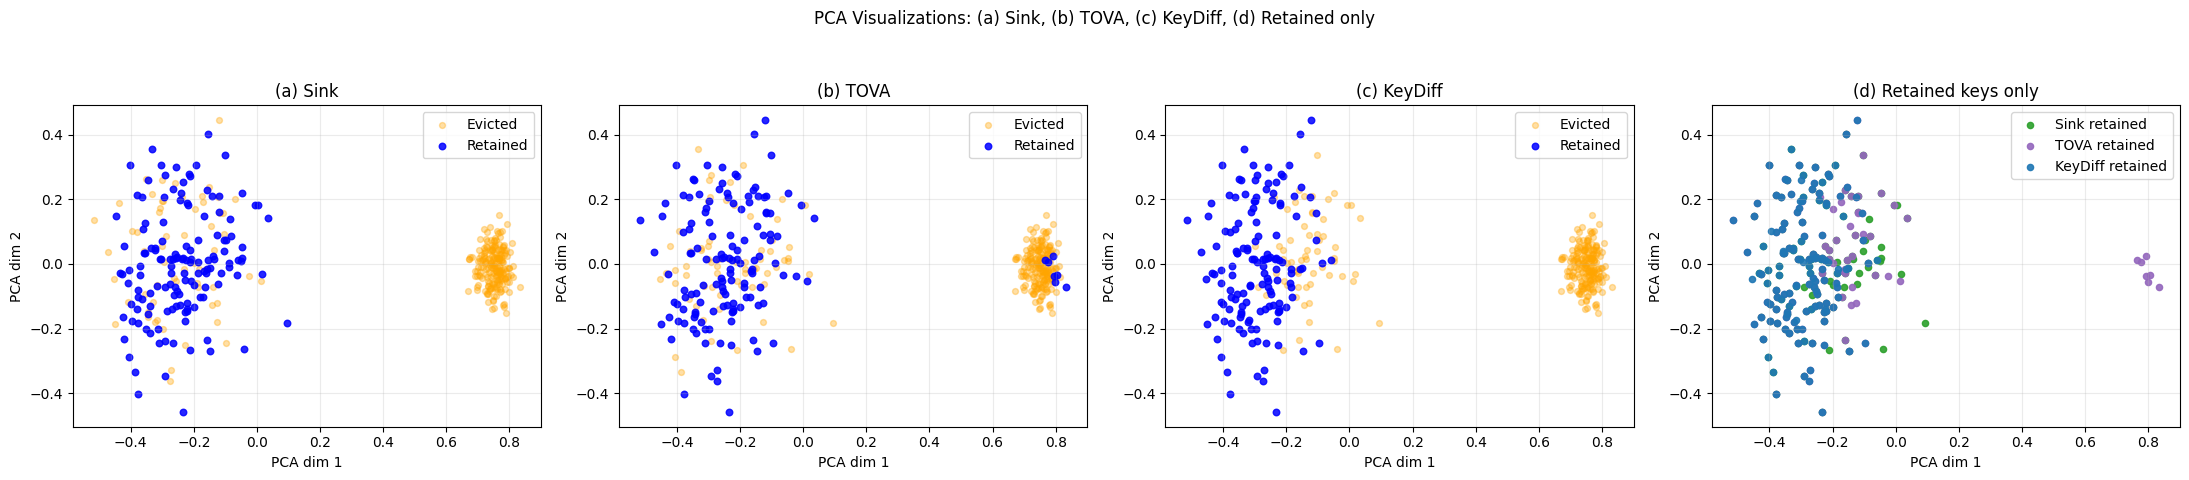

KeyDiff kept indices (example first 20): [200, 201, 202, 205, 206, 208, 209, 210, 212, 213, 214, 215, 216, 217, 219, 221, 222, 223, 224, 225]
TOVA kept indices (example first 20): [5, 20, 49, 99, 101, 114, 195, 200, 201, 202, 203, 205, 207, 208, 210, 211, 212, 213, 214, 215]
Sink kept indices (example first 20): [260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279]


In [8]:
visualize_policies()